# VNS data
## 3 datasets .. (data_dict is just descriptions of variables)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
data_dictionary = pd.read_excel('VNSNY Data Science Take Home Analysis 1.xlsx', sheet_name = 'data_dictionary')
data_dictionary

,TABLE,COLUMN,DESCRIPTION
0,patient,patient_id,patient identifier
1,patient,admission_dt,home health care admission date
2,patient,discharge_dt,home health care discharge date
3,patient,gender,patient gender
4,patient,date_of_birth,patient date of birth
5,patient,dyspnea_severity,dyspnea severity of patient at time time of ho...
6,patient,medication_count,count of medications prescribed to patient at ...
7,patient,sysupdate_timestamp,date that the information contained in the row...
8,diagnoses,patient_id,patient identifier
9,diagnoses,diagnosis,patient diagnosis at time time of home health ...


In [3]:
patient = pd.read_excel('VNSNY Data Science Take Home Analysis 1.xlsx', sheet_name = 'patient')
patient = patient.sort_values(by='patient_id')
#patient.dtypes

# Total Number of Patients:
size = patient['patient_id'].unique()
print("There are", size.size, "patients")

There are 37421 patients


## Creating episode length variable

In [4]:
#lets create episode length as an INT !
patient['length'] = patient['discharge_dt'] - patient['admission_dt'] 
patient['length'] = patient['length'].map(lambda x: str(x)[:-14]) #removing everything to get just the INT
patient['length'] = pd.to_numeric(patient['length']) 

patient.head(3)

,patient_id,admission_dt,discharge_dt,gender,date_of_birth,dyspnea_severity,medication_count,sysupdate_timestamp,length
13474,1,2014-01-01,2014-03-06,Female,1947-06-06,0,13,2014-03-07,64
9084,2,2014-01-01,2014-01-20,Female,1945-04-27,0,10,2014-01-21,19
16777,3,2014-01-01,2014-03-28,Male,1953-08-03,1,7,2014-03-29,86


In [5]:
print("Latest admission is:", patient['admission_dt'].max())
print("Earliest admission is:", patient['admission_dt'].min())
print("Latest discharge is:", patient['discharge_dt'].max())
print("Earliest Discharge is:", patient['discharge_dt'].min())

Latest admission is: 2014-12-31 00:00:00
Earliest admission is: 2014-01-01 00:00:00
Latest discharge is: 2016-01-26 00:00:00
Earliest Discharge is: 2014-01-02 00:00:00


### Maybe treatment length goes down over a bigger time span, bc treatment gets better as time goes on

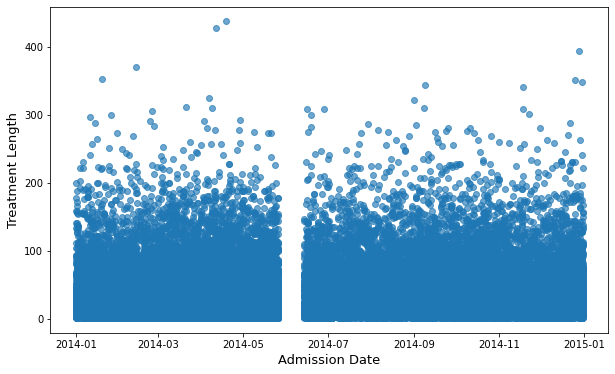

In [16]:
#as time went on, did length increase or decrease .. no correlation
plt.figure(figsize=(10,6))
plt.scatter(patient['admission_dt'], patient.length, alpha=.65)
plt.ylabel('Treatment Length', fontsize=13)
plt.xlabel("Admission Date",fontsize=13)
plt.show()

In [17]:
#No June Admissions
patient[patient['admission_dt'] == '2014-06']

,patient_id,admission_dt,discharge_dt,gender,date_of_birth,dyspnea_severity,medication_count,sysupdate_timestamp,length


## Looking at ages of patients

In [18]:
print('Avg patient age:', patient['date_of_birth'].mean())
print('Youngest Patient:', patient['date_of_birth'].max()) #Clearly an anomaly and bad data
print('Oldest Patient:', patient['date_of_birth'].min()) #Could be dead, this would be something going forward to make analysis better

Avg patient age: 1942-02-10 02:06:37.810238592
Youngest Patient: 2054-09-05 00:00:00
Oldest Patient: 1891-01-20 00:00:00


In [19]:
#Hey i mean these people could have died, just dont know really
patient[patient['date_of_birth'] < '1900-01-01'][['patient_id','date_of_birth']]

,patient_id,date_of_birth
9640,4817,1896-02-17
1899,7029,1897-08-23
36836,10049,1899-07-17
8774,15479,1899-01-13
36812,23977,1898-04-03
37074,25917,1891-01-20


In [20]:
patient[patient['date_of_birth'] > '2022-01-01'][['patient_id','date_of_birth']]
#4 patients born in 2054, 2035, 2050, 2032

,patient_id,date_of_birth
36098,3722,2054-09-05
29269,14985,2035-12-08
29278,26622,2050-04-03
11959,35205,2032-06-14


In [21]:
patient['date_of_birth'][36098] = '1954-09-05'
patient['date_of_birth'][29269] = '1935-09-05'
patient['date_of_birth'][29278] = '1950-09-05'
patient['date_of_birth'][11959] = '1932-09-05'
#patient[patient['patient_id']][['patient_id','date_of_birth']]
patient.loc[[36098, 29269,29278,11959]][['patient_id','date_of_birth']]

,patient_id,date_of_birth
36098,3722,1954-09-05
29269,14985,1935-09-05
29278,26622,1950-09-05
11959,35205,1932-09-05


In [22]:
patient.describe()
# count of patients below being 37452 is perfect, because 37452 - 31(28 patients with an extra episode, 
# AND + 3 patients having ANOTHER extra episode) = our patient count at 37421

,patient_id,dyspnea_severity,medication_count,length
count,37452.00000,37452.000000,37452.000000,37452.000000
mean,19756.19027,0.695156,7.783056,40.828474
std,11612.15915,0.833765,2.788765,40.110332
min,1.00000,0.000000,0.000000,1.000000
25%,9357.75000,0.000000,6.000000,12.000000
50%,20588.50000,1.000000,8.000000,29.000000
75%,29939.25000,1.000000,10.000000,56.000000
max,39293.00000,7.000000,22.000000,437.000000


## Finding duplicate episode entries

In [23]:
total = (
    patient.groupby(['patient_id'])
    .agg({'admission_dt':'count'})
    .reset_index()
    .sort_values(by=['admission_dt'],ascending=False)
    .reset_index(drop=True)
    )
total.head(4) 
# Showing that out of 37421 patients,  28 have had more than one episode.. 
# the most being 3 with this just being 3 patients

,patient_id,admission_dt
0,31041,3
1,30651,3
2,28205,3
3,751,2


In [24]:
#patient with more than one episode we see is a mistake
patient[patient['patient_id'] == 31041]

,patient_id,admission_dt,discharge_dt,gender,date_of_birth,dyspnea_severity,medication_count,sysupdate_timestamp,length
11956,31041,2014-10-12,2014-11-22,male,NaT,0,8,2014-11-23,41
24077,31041,2014-10-12,2014-11-22,male,1964-05-07,0,8,2014-12-03,41
25628,31041,2014-10-12,2014-11-22,male,1964-05-07,0,8,2014-12-02,41


In [25]:
patient = patient.sort_values(by=['date_of_birth', 'gender', 'discharge_dt', 'admission_dt', 'patient_id', 'dyspnea_severity', 'medication_count', 'sysupdate_timestamp'])
# sorting by all these just in case there is a NaN value, because when we drop duplicates 
# we are going to keep only the top row. So we dont want the top rows of duplicates to have NaN values


patient = patient.drop_duplicates(subset=['patient_id'], keep='first')
patient[patient['patient_id'] == 31041] #checking.. no duplicates :)

,patient_id,admission_dt,discharge_dt,gender,date_of_birth,dyspnea_severity,medication_count,sysupdate_timestamp,length
25628,31041,2014-10-12,2014-11-22,male,1964-05-07,0,8,2014-12-02,41


In [26]:
#Further Checking, False = no duplicates
boolean = not patient["patient_id"].is_unique
boolean = patient['patient_id'].duplicated().any()
boolean

False

## Quick gender fix

In [27]:
#how many males and females
patient['gender'].value_counts()
#note that i changed this

Female    22300
Male      14992
female       82
male         46
Name: gender, dtype: int64

In [29]:
#fixing this^
patient['gender'] = patient['gender'].replace(to_replace='female', value='Female')
patient['gender'] = patient['gender'].replace(to_replace='male', value='Male')
patient['gender'].value_counts()

Female    22382
Male      15038
Name: gender, dtype: int64

In [221]:
patient['dyspnea_severity'].value_counts()

0    18671
1    12985
2     4507
3     1050
4      184
5       18
6        4
7        2
Name: dyspnea_severity, dtype: int64

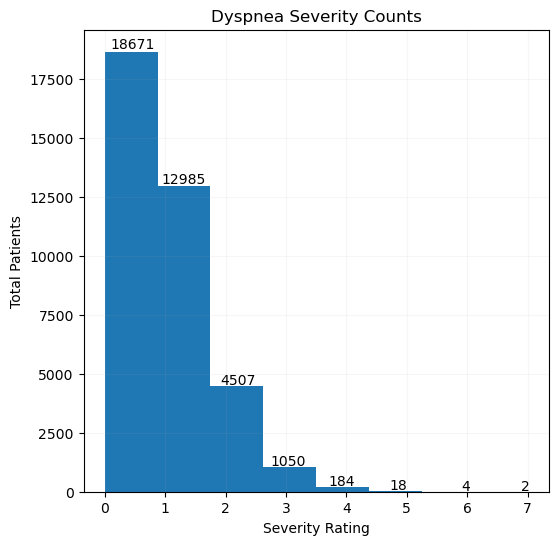

In [222]:
plt.figure(figsize=(6,6))
plt.hist(patient['dyspnea_severity'], bins=8, align='mid')
plt.grid(True, alpha=.1)
plt.text(.1, 18800, "18671")
plt.text(.94,13100, "12985")
plt.text(1.92, 4550,"4507")
plt.text(2.75,1110, "1050")
plt.text(3.71,270, "184")
plt.text(4.72,90, "18")
plt.text(5.9,40, "4")
plt.text(6.9,40, "2")
plt.xlabel('Severity Rating')
plt.title('Dyspnea Severity Counts')
plt.ylabel('Total Patients')
plt.show()

## Now opening up the important diagnoses

In [31]:
diagnoses = pd.read_excel('VNSNY Data Science Take Home Analysis 1.xlsx', sheet_name = 'diagnoses')
diagnoses.sort_values(by='patient_id').head()

,patient_id,diagnosis
29627,1,ARTHRITIS
32288,1,HYPERTENSION
25296,1,PULMONARY DISEASE
20807,2,CHF
24095,3,HYPERTENSION


In [33]:
diagnoses['diagnosis'].unique()

array(['ARTHRITIS', 'HYPERTENSION', 'DIABETES', 'CHF',
       'PULMONARY DISEASE', 'AMI', 'STROKE'], dtype=object)

In [36]:
diagnoses['diagnosis'].isna().sum()

0

In [39]:
diagnoses['diagnosis'].value_counts()

HYPERTENSION         11141
DIABETES              7498
ARTHRITIS             5795
CHF                   4816
PULMONARY DISEASE     4438
AMI                   4260
STROKE                3074
Name: diagnosis, dtype: int64

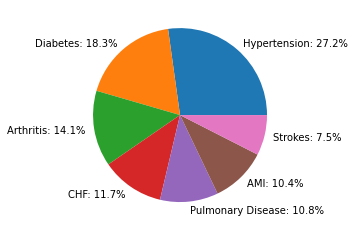

In [53]:
injuries = ["Hypertension: 27.2%", "Diabetes: 18.3%", "Arthritis: 14.1%", "CHF: 11.7%", "Pulmonary Disease: 10.8%", "AMI: 10.4%", "Strokes: 7.5%"]
percent = [27.2, 18.3, 14.1, 11.7, 10.8, 10.4, 7.5]

plt.figure(figsize=(6,4))
plt.pie(percent, labels=injuries)
plt.show()

## Also important hospitalizations

In [173]:
hospitals = pd.read_excel('VNSNY Data Science Take Home Analysis 1.xlsx', sheet_name = 'hospitalizations')
hospitals = hospitals.sort_values(by='hospitalization_dt').reset_index()
hospitals
#not every patient has a hospitalization

,index,patient_id,hospitalization_dt
0,25,48,2014-01-02
1,40,96,2014-01-02
2,14,28,2014-01-02
3,1,3,2014-01-03
4,37,91,2014-01-03
...,...,...,...
15392,15165,38800,2015-06-16
15393,13128,34192,2015-07-03
15394,15343,39207,2015-07-08
15395,9640,26612,2015-07-11


In [38]:
hospitals['hospitalization_dt'].isna().sum()


0

In [174]:
hospitals['hospitalization_dt'][1]

Timestamp('2014-01-02 00:00:00')

## Plotted to see gap in data in April

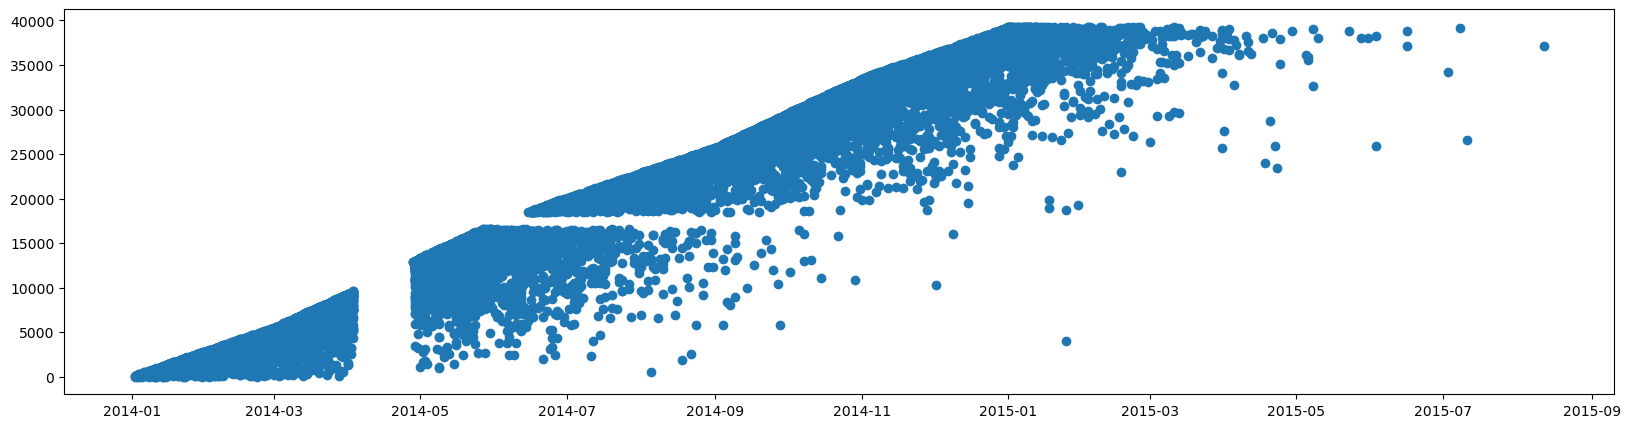

In [186]:
plt.figure(figsize=(20,5))
plt.scatter(hospitals['hospitalization_dt'],hospitals['patient_id'])
plt.show()

In [211]:
#No hospitalizations from 4/4 to 4/27
print(hospitals[hospitals['hospitalization_dt'] == '2014-04-4'])
print(hospitals[hospitals['hospitalization_dt'] == '2014-04-27'])

Empty DataFrame
Columns: [index, patient_id, hospitalization_dt]
Index: []
Empty DataFrame
Columns: [index, patient_id, hospitalization_dt]
Index: []


## How many Hospitalizations per patient

In [164]:
hosp = (
    hospitals.groupby(['patient_id'])
    .agg({'hospitalization_dt':'count'})
    .reset_index()
    .sort_values(by=['hospitalization_dt'],ascending=False)
    .reset_index(drop=True)
    )
hosp

,patient_id,hospitalization_dt
0,23797,6
1,31220,5
2,27141,5
3,29929,5
4,35553,5
...,...,...
12418,15552,1
12419,15555,1
12420,15556,1
12421,15559,1


## How many diagnoses per patient

In [214]:
diag = (
    diagnoses.groupby(['patient_id'])
    .agg({'diagnosis':'count'})
    .reset_index()
    .sort_values(by=['diagnosis'],ascending=False)
    .reset_index(drop=True)
    )
diag

,patient_id,diagnosis
0,38598,6
1,37256,6
2,12671,5
3,34573,5
4,38108,5
...,...,...
25574,2589,1
25575,19758,1
25576,2583,1
25577,19761,1


## Plot Correlation function

In [56]:
#rx and ry are coordinates of where the plt.text goes
def plot_corr(df, col1, col2, title, rx, ry):
    x = df[col1]
    y = df[col2]
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    rsqr = r_value**2

    
    fig, ax = plt.subplots()
    df[[col1,col2]].plot(kind='scatter', x=col1, y=col2, 
                                                           title=title, ax=ax)
    ax.plot(x, intercept+(slope*x), color='grey', linestyle='--')
    ax.text(rx, ry, '$R^2 = %0.4f$'%rsqr, fontsize=20)

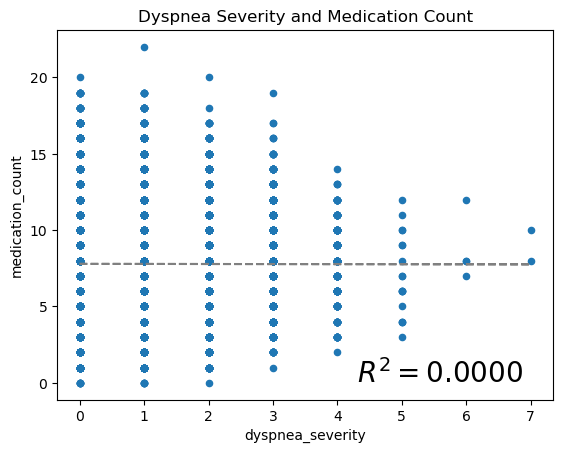

In [215]:
plot_corr(patient, 'dyspnea_severity', 'medication_count', 'Dyspnea Severity and Medication Count', 4.3, 0)


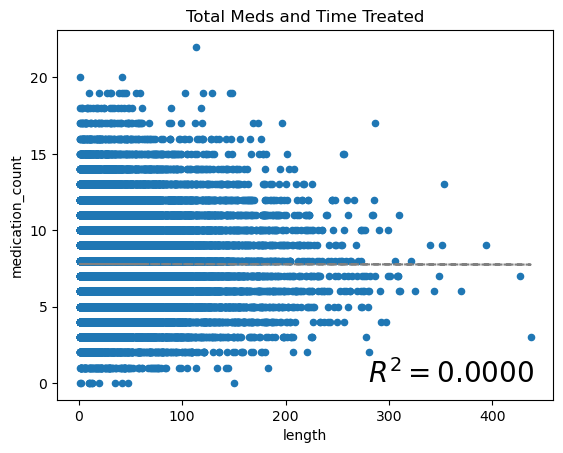

In [216]:
plot_corr(patient, 'length', 'medication_count', 'Total Meds and Time Treated', 280,0)

# Joining diagnosis and hospitals into patient

In [228]:
print(patient['patient_id'].size)
patient.head(1)

37421


,patient_id,admission_dt,discharge_dt,gender,date_of_birth,dyspnea_severity,medication_count,sysupdate_timestamp,length
37074,25917,2014-09-02,2014-11-02,Male,1891-01-20,0,10,2014-11-03,61


In [229]:
print(diag['patient_id'].size)
diag.head(2)

25579


,patient_id,diagnosis
0,38598,6
1,37256,6


## Adding the total diagnoses per patient

In [230]:
patient = pd.merge(patient,diag,left_on='patient_id',right_on='patient_id',how='left')

In [239]:
patient['diagnosis'] = patient['diagnosis'].fillna(0)
patient

,patient_id,admission_dt,discharge_dt,gender,date_of_birth,dyspnea_severity,medication_count,sysupdate_timestamp,length,diagnosis
0,25917,2014-09-02,2014-11-02,Male,1891-01-20,0,10,2014-11-03,61,3.0
1,4817,2014-02-21,2014-03-15,Female,1896-02-17,0,5,2014-03-16,22,1.0
2,7029,2014-03-13,2014-03-17,Male,1897-08-23,1,7,2014-03-18,4,1.0
3,23977,2014-08-13,2014-09-01,Female,1898-04-03,0,8,2014-09-02,19,2.0
4,15479,2014-05-18,2014-06-21,Female,1899-01-13,3,9,2014-06-22,34,3.0
...,...,...,...,...,...,...,...,...,...,...
37416,7337,2014-03-15,2014-03-26,Female,1983-10-04,0,13,2014-03-27,11,1.0
37417,38648,2014-12-25,2015-01-26,Male,1984-08-03,0,5,2015-01-27,32,0.0
37418,22834,2014-07-31,2014-09-08,Male,1985-06-18,1,10,2014-09-09,39,0.0
37419,36623,2014-12-04,2015-01-11,Female,1985-09-20,0,5,2015-01-12,38,2.0


## Now adding the total hospitalizations per patient

In [247]:
#now we can add total hospitalizations too
patient = pd.merge(patient,hosp,left_on='patient_id',right_on='patient_id',how='left')
patient['hospitalization_dt'] = patient['hospitalization_dt'].fillna(0)
patient

,patient_id,admission_dt,discharge_dt,gender,date_of_birth,dyspnea_severity,medication_count,sysupdate_timestamp,length,diagnosis,hospitalization_dt
0,25917,2014-09-02,2014-11-02,Male,1891-01-20,0,10,2014-11-03,61,3.0,0.0
1,4817,2014-02-21,2014-03-15,Female,1896-02-17,0,5,2014-03-16,22,1.0,0.0
2,7029,2014-03-13,2014-03-17,Male,1897-08-23,1,7,2014-03-18,4,1.0,2.0
3,23977,2014-08-13,2014-09-01,Female,1898-04-03,0,8,2014-09-02,19,2.0,0.0
4,15479,2014-05-18,2014-06-21,Female,1899-01-13,3,9,2014-06-22,34,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
37416,7337,2014-03-15,2014-03-26,Female,1983-10-04,0,13,2014-03-27,11,1.0,1.0
37417,38648,2014-12-25,2015-01-26,Male,1984-08-03,0,5,2015-01-27,32,0.0,0.0
37418,22834,2014-07-31,2014-09-08,Male,1985-06-18,1,10,2014-09-09,39,0.0,0.0
37419,36623,2014-12-04,2015-01-11,Female,1985-09-20,0,5,2015-01-12,38,2.0,1.0


In [253]:
#patients with 0 diagnosis
diag_count = (
    patient.groupby(['diagnosis'])
    .agg({'hospitalization_dt':'sum'})
    .reset_index()
    .sort_values(by=['hospitalization_dt'],ascending=False)
    .reset_index(drop=True)
    ) 
diag_count

,diagnosis,hospitalization_dt
0,1.0,5677.0
1,0.0,4209.0
2,2.0,3723.0
3,3.0,1445.0
4,4.0,308.0
5,5.0,32.0
6,6.0,3.0


## Above is hosps per diagnosis amount, below is total people with each diagnosis amount

### Divide to find the rate
### 40.2 % chance for ppl with 1 diagnosis to be hospitalized .. etc

In [254]:
patient['diagnosis'].value_counts()

1.0    14118
0.0    11842
2.0     8130
3.0     2739
4.0      535
5.0       55
6.0        2
Name: diagnosis, dtype: int64

### But I also want to see what specific diagnoses are linked to hospitalization amounts

In [249]:
#it worked!
new_diag = pd.merge(diagnoses,hosp,left_on='patient_id',right_on='patient_id',how='left')
new_diag['hospitalization_dt'] = new_diag['hospitalization_dt'].fillna(0)
new_diag = new_diag.sort_values(by='patient_id')
new_diag.head(10)

,patient_id,diagnosis,hospitalization_dt
29627,1,ARTHRITIS,0.0
32288,1,HYPERTENSION,0.0
25296,1,PULMONARY DISEASE,0.0
20807,2,CHF,1.0
24095,3,HYPERTENSION,1.0
16653,4,DIABETES,1.0
30808,6,PULMONARY DISEASE,1.0
29928,6,HYPERTENSION,1.0
14616,7,AMI,0.0
30607,7,STROKE,0.0


In [252]:
bad = (
    new_diag.groupby(['diagnosis'])
    .agg({'hospitalization_dt':'sum'})
    .reset_index()
    .sort_values(by=['hospitalization_dt'],ascending=False)
    .reset_index(drop=True)
    )
bad

,diagnosis,hospitalization_dt
0,HYPERTENSION,5309.0
1,DIABETES,3688.0
2,CHF,2638.0
3,ARTHRITIS,2117.0
4,PULMONARY DISEASE,1971.0
5,AMI,1749.0
6,STROKE,1396.0


## Below is total diagnoses, above is hospitals per diagnosis. Divide them to find %
#### hypertension = 47.7% of all hypertension diagnoses went to the hospital

In [250]:
diagnoses['diagnosis'].value_counts()

HYPERTENSION         11141
DIABETES              7498
ARTHRITIS             5795
CHF                   4816
PULMONARY DISEASE     4438
AMI                   4260
STROKE                3074
Name: diagnosis, dtype: int64

## No corr between DOB and hospitilzations

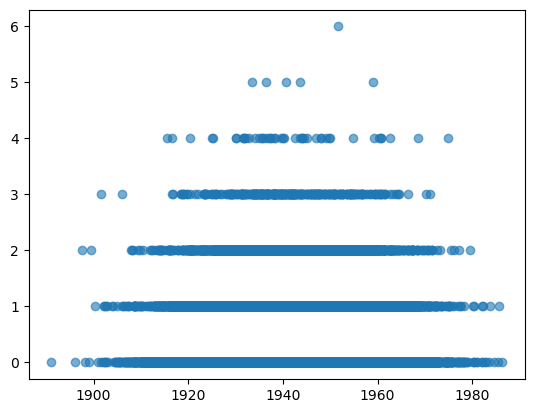

In [276]:
plt.scatter(patient['date_of_birth'], patient['amount_of_hospitalizations'], alpha=.6)
plt.show()

In [268]:
patient = patient.rename(columns = {'length':'length_of_treatment', 'hospitalization_dt':'amount_of_hospitalizations', 'diagnosis':'amount_of_diagnoses'})

## Lets add a binary column to see if a patient was hospitalized at all or not

In [272]:
patient['hospitalized?'] = patient['amount_of_hospitalizations']
patient['hospitalized?'] = patient['hospitalized?'].replace(to_replace=2, value=1)
patient['hospitalized?'] = patient['hospitalized?'].replace(to_replace=3, value=1)
patient['hospitalized?'] = patient['hospitalized?'].replace(to_replace=4, value=1)
patient['hospitalized?'] = patient['hospitalized?'].replace(to_replace=5, value=1)
patient['hospitalized?'] = patient['hospitalized?'].replace(to_replace=6, value=1)
patient['hospitalized?'].value_counts()

0.0    24998
1.0    12423
Name: hospitalized?, dtype: int64

In [340]:
#Looking at just hospitalizations after episodes end
new_patient = pd.merge(patient,hospitals,left_on='patient_id',right_on='patient_id',how='left')
new_patient.head(2)

,patient_id,admission_dt,discharge_dt,gender,date_of_birth,dyspnea_severity,medication_count,sysupdate_timestamp,length_of_treatment,amount_of_diagnoses,amount_of_hospitalizations,hospitalized?,index,hospitalization_dt
0,25917,2014-09-02,2014-11-02,Male,1891-01-20,0,10,2014-11-03,61,3.0,0.0,0.0,NaN,NaT
1,4817,2014-02-21,2014-03-15,Female,1896-02-17,0,5,2014-03-16,22,1.0,0.0,0.0,NaN,NaT


In [285]:
time_after = new_patient[new_patient['hospitalization_dt'] > new_patient['discharge_dt']]
time_after['amount_of_time'] = time_after['hospitalization_dt'] - time_after['discharge_dt']
time_after[['amount_of_time']].describe()

,amount_of_time
count,92
mean,1 days 02:52:10.434782608
std,0 days 07:49:46.294460487
min,1 days 00:00:00
25%,1 days 00:00:00
50%,1 days 00:00:00
75%,1 days 00:00:00
max,2 days 00:00:00


In [320]:
time_after[['patient_id']].sort_values(by='patient_id')
deaths = time_after['patient_id'].unique()
deaths.size

81

## Whether hospitalized or not, every feature variable is the same average

In [337]:
nothosp = patient[patient['hospitalized?'] == 0]
nothosp['amount_of_diagnoses'].mean()

1.0491639331146492

In [338]:
yeshosp = patient[patient['hospitalized?'] == 1]
yeshosp['amount_of_diagnoses'].mean()

1.1909361667874105